In [38]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gc

In [39]:
from prj.config import DATA_DIR


BASE_PATH = DATA_DIR  / 'train'
partition = 3
train_ds = pl.concat([
    pl.scan_parquet(BASE_PATH / f'partition_id={i}' / 'part-0.parquet')
    for i in range(partition, partition + 1)
]).collect()

In [40]:
parts = pl.concat([
    pl.scan_parquet(BASE_PATH / f'partition_id={i}' / 'part-0.parquet') \
        .select(['date_id', 'time_id', 'symbol_id']) \
        .with_columns(pl.lit(i).cast(pl.Int8).alias('part')).collect()
    for i in range(10)
])
parts.head()

shape: (5, 4)
┌─────────┬─────────┬───────────┬──────┐
│ date_id ┆ time_id ┆ symbol_id ┆ part │
│ ---     ┆ ---     ┆ ---       ┆ ---  │
│ i16     ┆ i16     ┆ i8        ┆ i8   │
╞═════════╪═════════╪═══════════╪══════╡
│ 0       ┆ 0       ┆ 1         ┆ 0    │
│ 0       ┆ 0       ┆ 7         ┆ 0    │
│ 0       ┆ 0       ┆ 9         ┆ 0    │
│ 0       ┆ 0       ┆ 10        ┆ 0    │
│ 0       ┆ 0       ┆ 14        ┆ 0    │
└─────────┴─────────┴───────────┴──────┘

In [41]:
responders = train_ds.select(['date_id', 'time_id', 'symbol_id'] + [f'responder_{i}' for i in range(9)])
responders.head()

shape: (5, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5          ┆ 6          ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 510     ┆ 0       ┆ 1         ┆ -0.100719  ┆ … ┆ 0.027439   ┆ 1.896684   ┆ 0.769314  ┆ 0.336645  │
│ 510     ┆ 0       ┆ 2         ┆ 0.261295   ┆ … ┆ -0.339655  ┆ -1.810862  ┆ -0.42353  ┆ -0.868464 │
│ 510     ┆ 0       ┆ 3         ┆ -0.745763  ┆ … ┆ 3.077065   ┆ 2.597628   ┆ -0.263473 ┆ 5.0       │
│ 510     ┆ 0       ┆ 5         ┆ -0.213052  ┆ … ┆ 0.137175   ┆ -0.476951  ┆ -0.722685 ┆ 0.127387  │
│ 510     ┆ 0       ┆ 7         ┆ 0.652055   ┆ … ┆ 0.483403   ┆ -0.760962  ┆ -0.502071 ┆ -0.709697 │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [42]:
train_ds.null_count().transpose(include_header=True).rename({'column_0': 'null_count'}).with_columns(
    pl.col('null_count').truediv(train_ds.shape[0]).mul(100).alias('null_count_pct')
).sort('null_count', descending=True).head(10)

shape: (10, 3)
┌────────────┬────────────┬────────────────┐
│ column     ┆ null_count ┆ null_count_pct │
│ ---        ┆ ---        ┆ ---            │
│ str        ┆ u32        ┆ f64            │
╞════════════╪════════════╪════════════════╡
│ feature_39 ┆ 600679     ┆ 14.954227      │
│ feature_42 ┆ 600679     ┆ 14.954227      │
│ feature_50 ┆ 598814     ┆ 14.907797      │
│ feature_53 ┆ 598814     ┆ 14.907797      │
│ feature_21 ┆ 427047     ┆ 10.631565      │
│ feature_26 ┆ 427047     ┆ 10.631565      │
│ feature_27 ┆ 427047     ┆ 10.631565      │
│ feature_31 ┆ 427047     ┆ 10.631565      │
│ feature_41 ┆ 133099     ┆ 3.313571       │
│ feature_44 ┆ 133099     ┆ 3.313571       │
└────────────┴────────────┴────────────────┘

In [43]:
lags = pl.read_parquet(DATA_DIR / 'lags/date_id=0/part-0.parquet')
lags.head()

shape: (5, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0_lag_1    ┆   ┆ 5_lag_1    ┆ 6_lag_1    ┆ _7_lag_1  ┆ _8_lag_1  │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 0       ┆ 0       ┆ 0         ┆ -0.442215  ┆ … ┆ -0.036595  ┆ -1.305746  ┆ -0.795677 ┆ -0.143724 │
│ 0       ┆ 0       ┆ 1         ┆ -0.651829  ┆ … ┆ -0.615652  ┆ -1.162801  ┆ -1.205924 ┆ -1.245934 │
│ 0       ┆ 0       ┆ 2         ┆ -0.656373  ┆ … ┆ -0.378265  ┆ -1.57429   ┆ -1.863071 ┆ -0.027343 │
│ 0       ┆ 0       ┆ 3         ┆ -0.188186  ┆ … ┆ -0.054984  ┆ 0.329152   ┆ -0.965471 ┆ 0.576635  │
│ 0       ┆ 0       ┆ 4         ┆ -0.257462  ┆ … ┆ -0.597093  ┆ 0.219856   ┆ -0.276356 ┆ -0.90479  │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

# Basic

In [44]:
parts.group_by('part').agg(
    pl.col('date_id').min().alias('min_date_id'),
    pl.col('date_id').max().alias('max_date_id'),
    pl.col('date_id').count().alias('num_samples')
)

shape: (10, 4)
┌──────┬─────────────┬─────────────┬─────────────┐
│ part ┆ min_date_id ┆ max_date_id ┆ num_samples │
│ ---  ┆ ---         ┆ ---         ┆ ---         │
│ i8   ┆ i16         ┆ i16         ┆ u32         │
╞══════╪═════════════╪═════════════╪═════════════╡
│ 0    ┆ 0           ┆ 169         ┆ 1944210     │
│ 1    ┆ 170         ┆ 339         ┆ 2804247     │
│ 2    ┆ 340         ┆ 509         ┆ 3036873     │
│ 3    ┆ 510         ┆ 679         ┆ 4016784     │
│ 4    ┆ 680         ┆ 849         ┆ 5022952     │
│ 5    ┆ 850         ┆ 1019        ┆ 5348200     │
│ 6    ┆ 1020        ┆ 1189        ┆ 6203912     │
│ 7    ┆ 1190        ┆ 1359        ┆ 6335560     │
│ 8    ┆ 1360        ┆ 1529        ┆ 6140024     │
│ 9    ┆ 1530        ┆ 1698        ┆ 6274576     │
└──────┴─────────────┴─────────────┴─────────────┘

In [45]:
symbol_stats = parts.group_by('symbol_id').agg(
    pl.col('date_id').min().alias('min_date_id'),
    pl.col('date_id').max().alias('max_date_id'),
    pl.col('date_id').n_unique().alias('num_dates'),
    pl.col('date_id').count().alias('num_samples'),
).sort('symbol_id')
symbol_stats.head()

shape: (5, 5)
┌───────────┬─────────────┬─────────────┬───────────┬─────────────┐
│ symbol_id ┆ min_date_id ┆ max_date_id ┆ num_dates ┆ num_samples │
│ ---       ┆ ---         ┆ ---         ┆ ---       ┆ ---         │
│ i8        ┆ i16         ┆ i16         ┆ u32       ┆ u32         │
╞═══════════╪═════════════╪═════════════╪═══════════╪═════════════╡
│ 0         ┆ 1           ┆ 1698        ┆ 1592      ┆ 1468466     │
│ 1         ┆ 0           ┆ 1698        ┆ 1678      ┆ 1543979     │
│ 2         ┆ 1           ┆ 1698        ┆ 1606      ┆ 1484398     │
│ 3         ┆ 2           ┆ 1698        ┆ 1565      ┆ 1446495     │
│ 4         ┆ 952         ┆ 1698        ┆ 706       ┆ 683408      │
└───────────┴─────────────┴─────────────┴───────────┴─────────────┘

Text(0.5, 1.0, 'Number of samples for each stock')

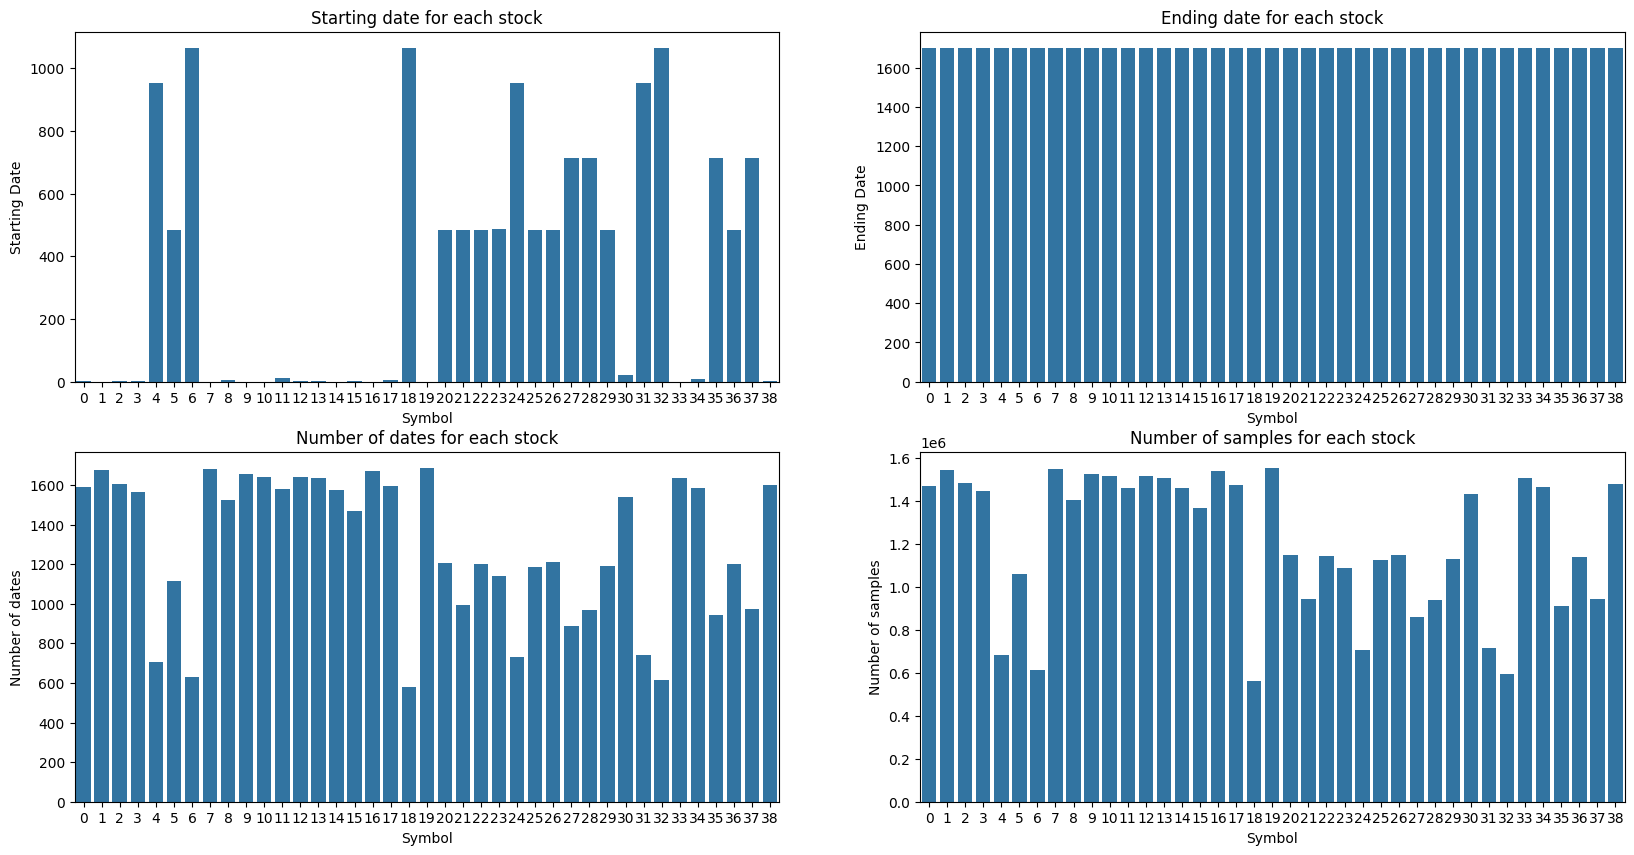

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

sns.barplot(ax=axes[0], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['min_date_id'].to_numpy())
axes[0].set_xlabel('Symbol')
axes[0].set_ylabel('Starting Date')
axes[0].set_title('Starting date for each stock')

sns.barplot(ax=axes[1], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['max_date_id'].to_numpy())
axes[1].set_xlabel('Symbol')
axes[1].set_ylabel('Ending Date')
axes[1].set_title('Ending date for each stock')

sns.barplot(ax=axes[2], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['num_dates'].to_numpy())
axes[2].set_xlabel('Symbol')
axes[2].set_ylabel('Number of dates')
axes[2].set_title('Number of dates for each stock')

sns.barplot(ax=axes[3], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['num_samples'].to_numpy())
axes[3].set_xlabel('Symbol')
axes[3].set_ylabel('Number of samples')
axes[3].set_title('Number of samples for each stock')

# Basic Correlations

In [47]:
correlations = train_ds.drop(['date_id', 'time_id', 'symbol_id', 'weight']).drop_nulls().corr()
correlations.head()

shape: (5, 88)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ feature_0 ┆ feature_0 ┆ feature_0 ┆ feature_0 ┆ … ┆ responder ┆ responder ┆ responder ┆ responde │
│ 0         ┆ 1         ┆ 2         ┆ 3         ┆   ┆ _5        ┆ _6        ┆ _7        ┆ r_8      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 1.0       ┆ 0.019782  ┆ 0.857329  ┆ 0.858553  ┆ … ┆ 0.001221  ┆ 0.000063  ┆ 0.000779  ┆ 0.000814 │
│ 0.019782  ┆ 1.0       ┆ -0.055311 ┆ -0.04703  ┆ … ┆ -0.009991 ┆ -0.016267 ┆ -0.009687 ┆ -0.00988 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 9        │
│ 0.857329  ┆ -0.055311 ┆ 1.0       ┆ 0.86171   ┆ … ┆ 0.002259  ┆ 0.002039  ┆ 0.001913  ┆ 0.001916 │
│ 0.858553  ┆ -0.04703  ┆ 0.86171   ┆ 1.0       ┆ … ┆ 0.001334  ┆ 0.001391  ┆ 0.001367  ┆ 0.00118  │
│ 0.001685  ┆ 0.261268  ┆ -0.048389 ┆ -0.018464 ┆ … ┆ -0.018787 ┆ -0.029999 ┆ -0.013617 ┆ -0.02368 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 5        │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

<Axes: >

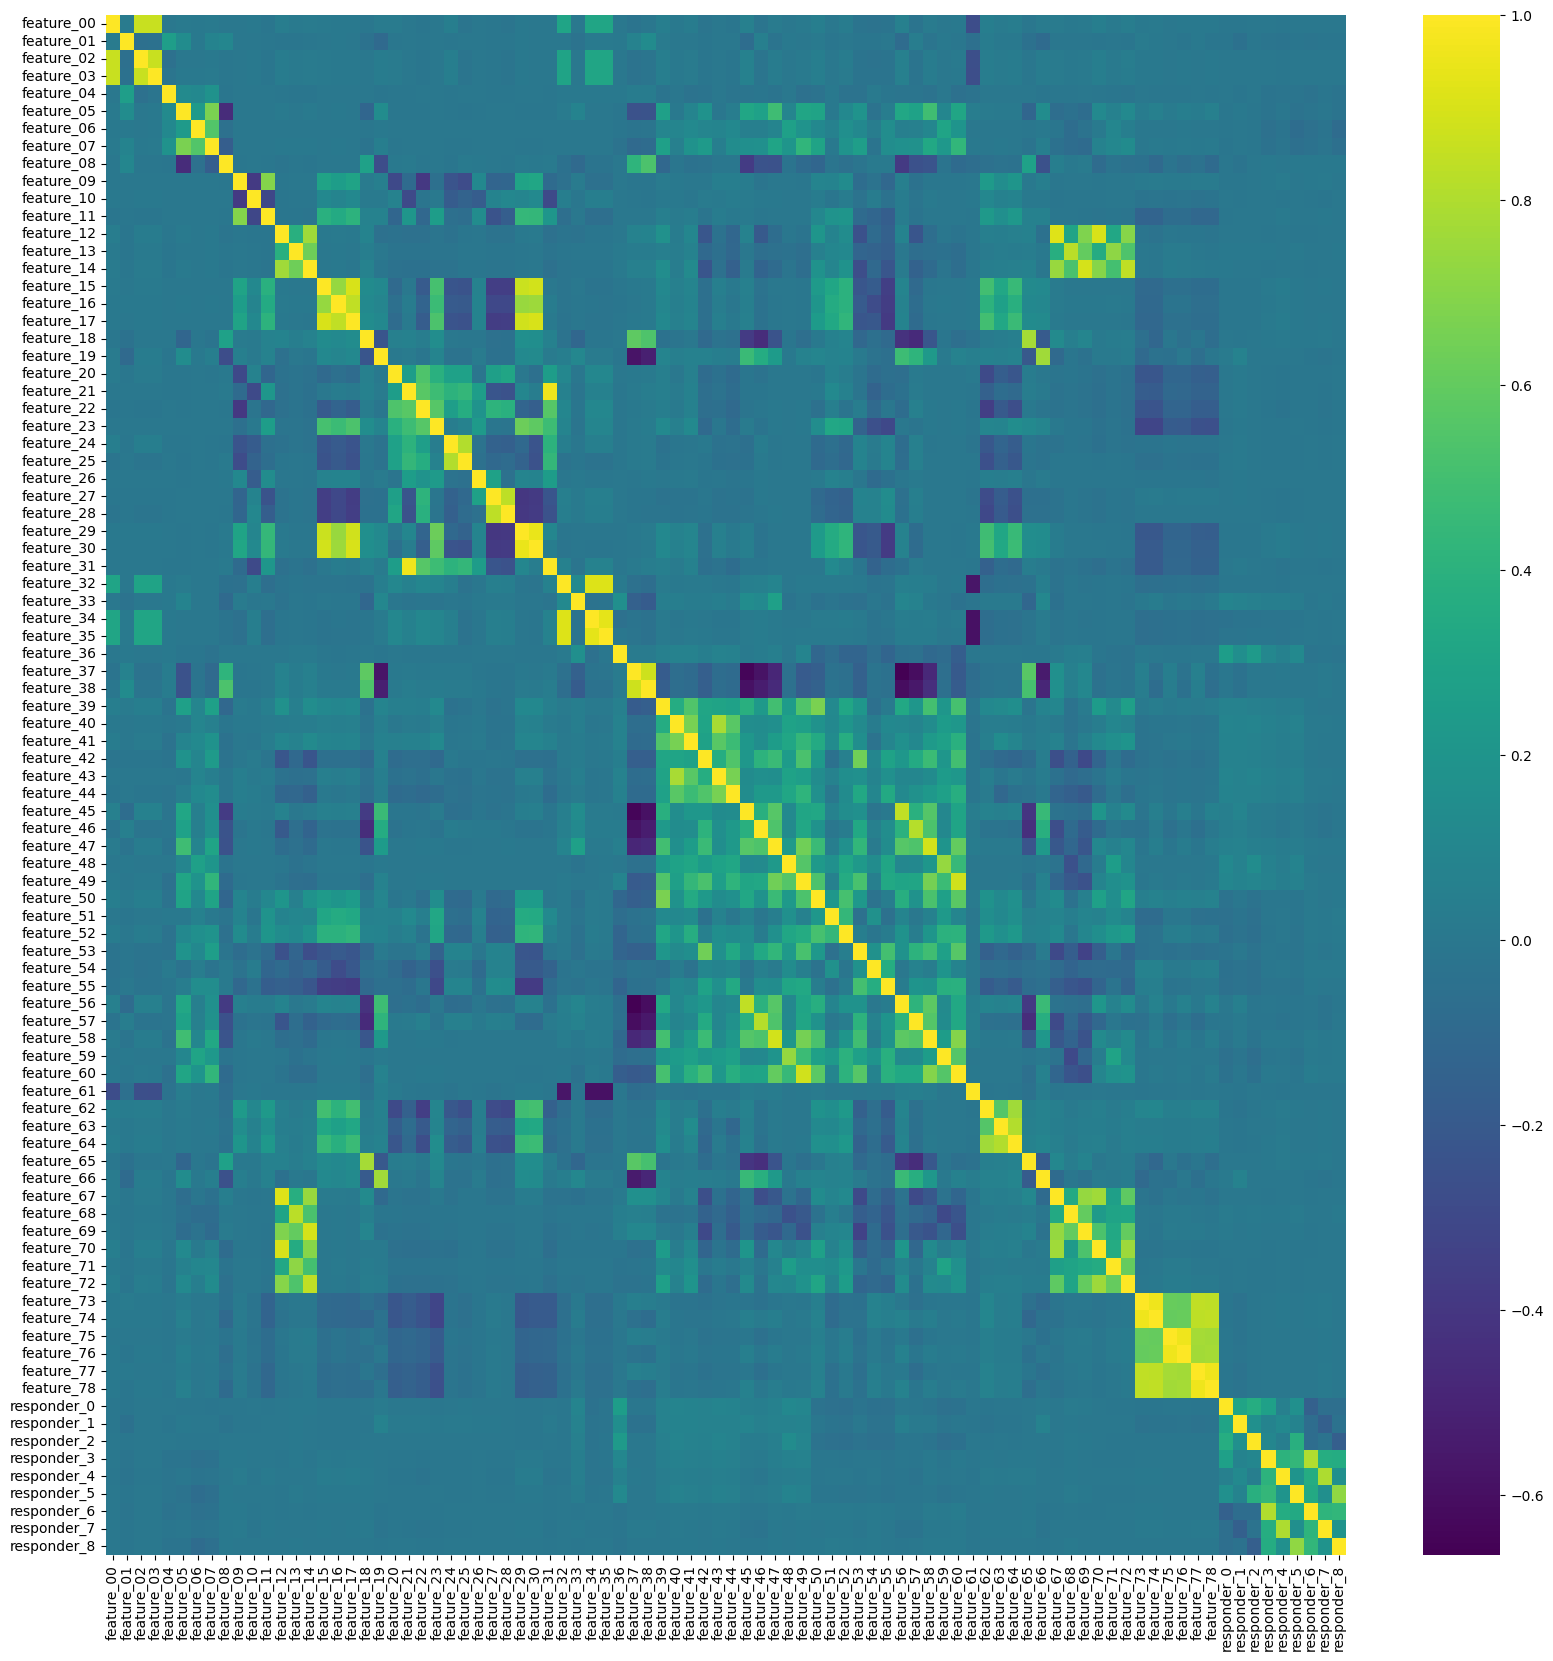

In [48]:
correlations = correlations.to_pandas()
correlations.index = correlations.columns.values

plt.figure(figsize=(20, 20))
sns.heatmap(correlations, cmap='viridis')

<Axes: >

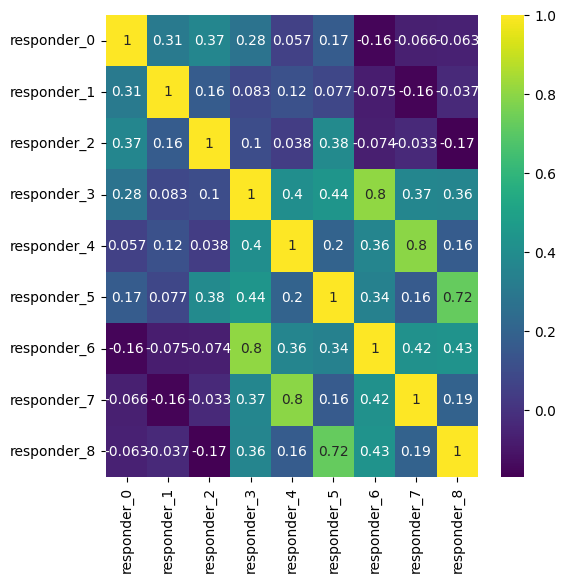

In [49]:
plt.figure(figsize=(6, 6))
sns.heatmap(correlations.iloc[-9:, -9:], cmap='viridis', annot=True)

Responder 6 and 3 are higly correlated

In [50]:
responders_tags = pl.read_csv(DATA_DIR / 'responders.csv')
responders_tags

shape: (9, 6)
┌─────────────┬───────┬───────┬───────┬───────┬───────┐
│ responder   ┆ tag_0 ┆ tag_1 ┆ tag_2 ┆ tag_3 ┆ tag_4 │
│ ---         ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ str         ┆ bool  ┆ bool  ┆ bool  ┆ bool  ┆ bool  │
╞═════════════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ responder_0 ┆ true  ┆ false ┆ true  ┆ false ┆ false │
│ responder_1 ┆ true  ┆ false ┆ false ┆ true  ┆ false │
│ responder_2 ┆ true  ┆ true  ┆ false ┆ false ┆ false │
│ responder_3 ┆ false ┆ false ┆ true  ┆ false ┆ true  │
│ responder_4 ┆ false ┆ false ┆ false ┆ true  ┆ true  │
│ responder_5 ┆ false ┆ true  ┆ false ┆ false ┆ true  │
│ responder_6 ┆ false ┆ false ┆ true  ┆ false ┆ false │
│ responder_7 ┆ false ┆ false ┆ false ┆ true  ┆ false │
│ responder_8 ┆ false ┆ true  ┆ false ┆ false ┆ false │
└─────────────┴───────┴───────┴───────┴───────┴───────┘

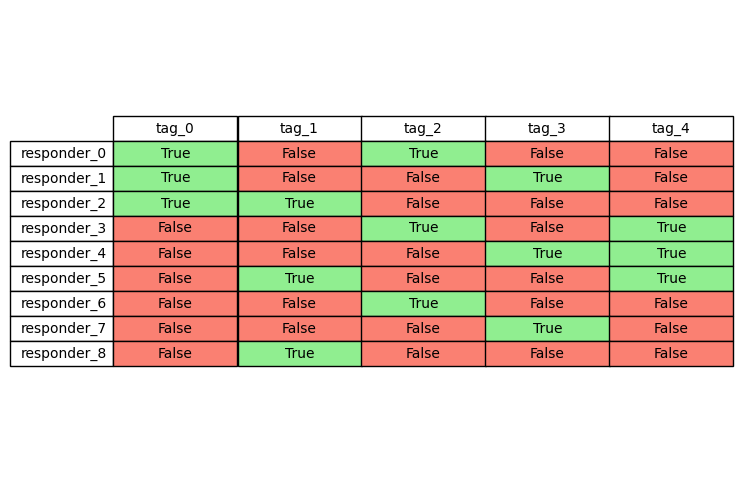

In [51]:
data = responders_tags.to_numpy()[:, 1:]

row_names = responders_tags['responder'].to_list()
col_names = responders_tags.columns[1:]

colors = np.where(data, "lightgreen", "salmon")

fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("tight")
ax.axis("off")
cell_text = np.where(data, "True", "False")
table = ax.table(
    cellText=cell_text,
    cellColours=colors,
    rowLabels=row_names,
    colLabels=col_names,
    loc="center",
    cellLoc="center"
)
table.scale(1, 1.5)
plt.show()


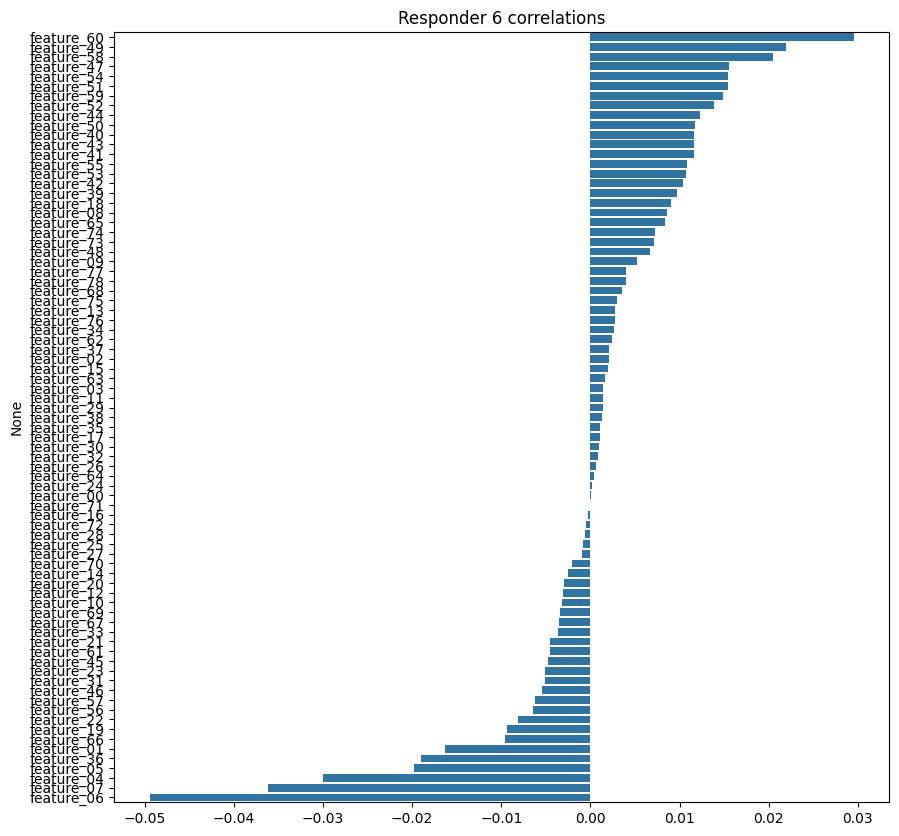

In [52]:
responder_6_correlations = correlations['responder_6'][:-9].sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(y=responder_6_correlations.index, x=responder_6_correlations.values)
plt.title('Responder 6 correlations');

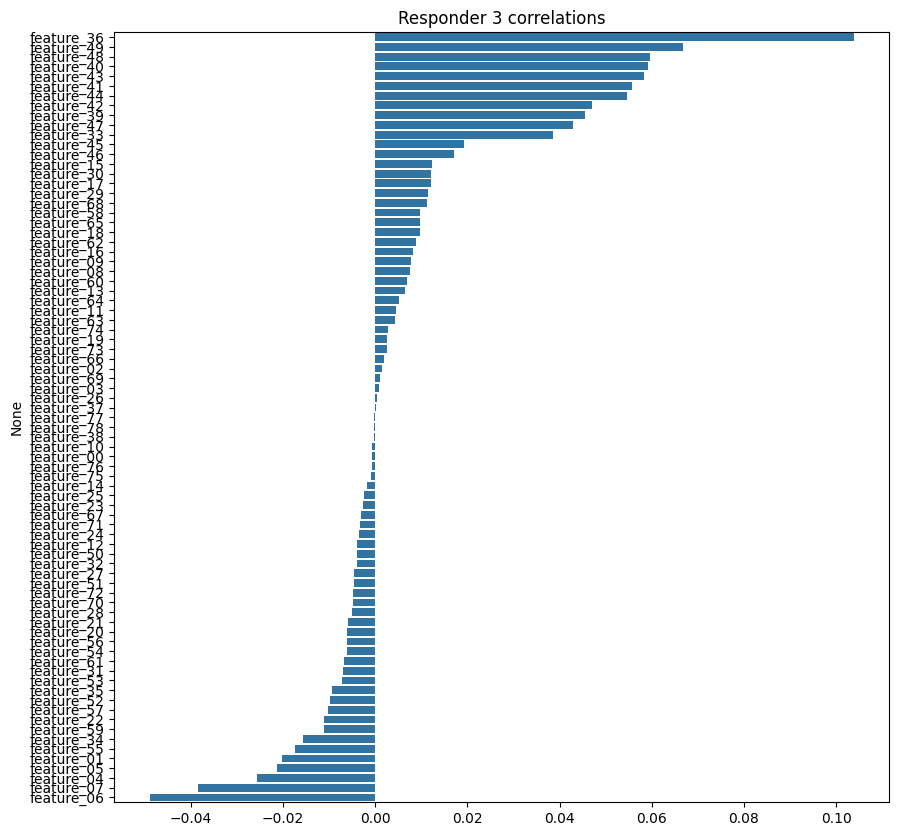

In [53]:
responder_3_correlations = correlations['responder_3'][:-9].sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(y=responder_3_correlations.index, x=responder_3_correlations.values)
plt.title('Responder 3 correlations');

# Responders

In [54]:
RESPONDERS = [f'responder_{i}' for i in range(9)]

In [55]:
stock_1_responders = responders.filter(pl.col('symbol_id') == 1)
stock_1_responders.head(3)

shape: (3, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5          ┆ 6          ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 510     ┆ 0       ┆ 1         ┆ -0.100719  ┆ … ┆ 0.027439   ┆ 1.896684   ┆ 0.769314  ┆ 0.336645  │
│ 510     ┆ 1       ┆ 1         ┆ -0.112081  ┆ … ┆ -0.159288  ┆ 1.617759   ┆ 0.801793  ┆ 0.065951  │
│ 510     ┆ 2       ┆ 1         ┆ -0.514019  ┆ … ┆ 0.019972   ┆ 2.130596   ┆ 0.911359  ┆ 0.636361  │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

<Axes: ylabel='Count'>

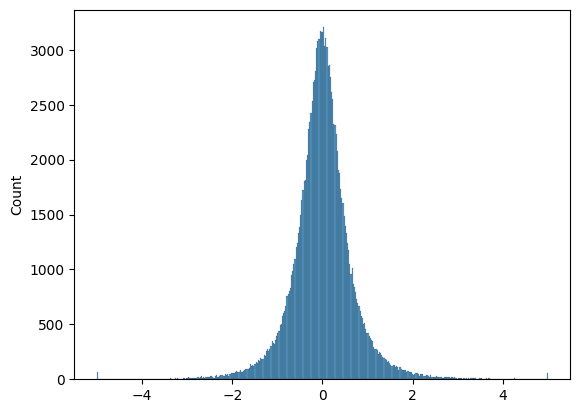

In [56]:
sns.histplot(stock_1_responders['responder_6'].to_numpy())

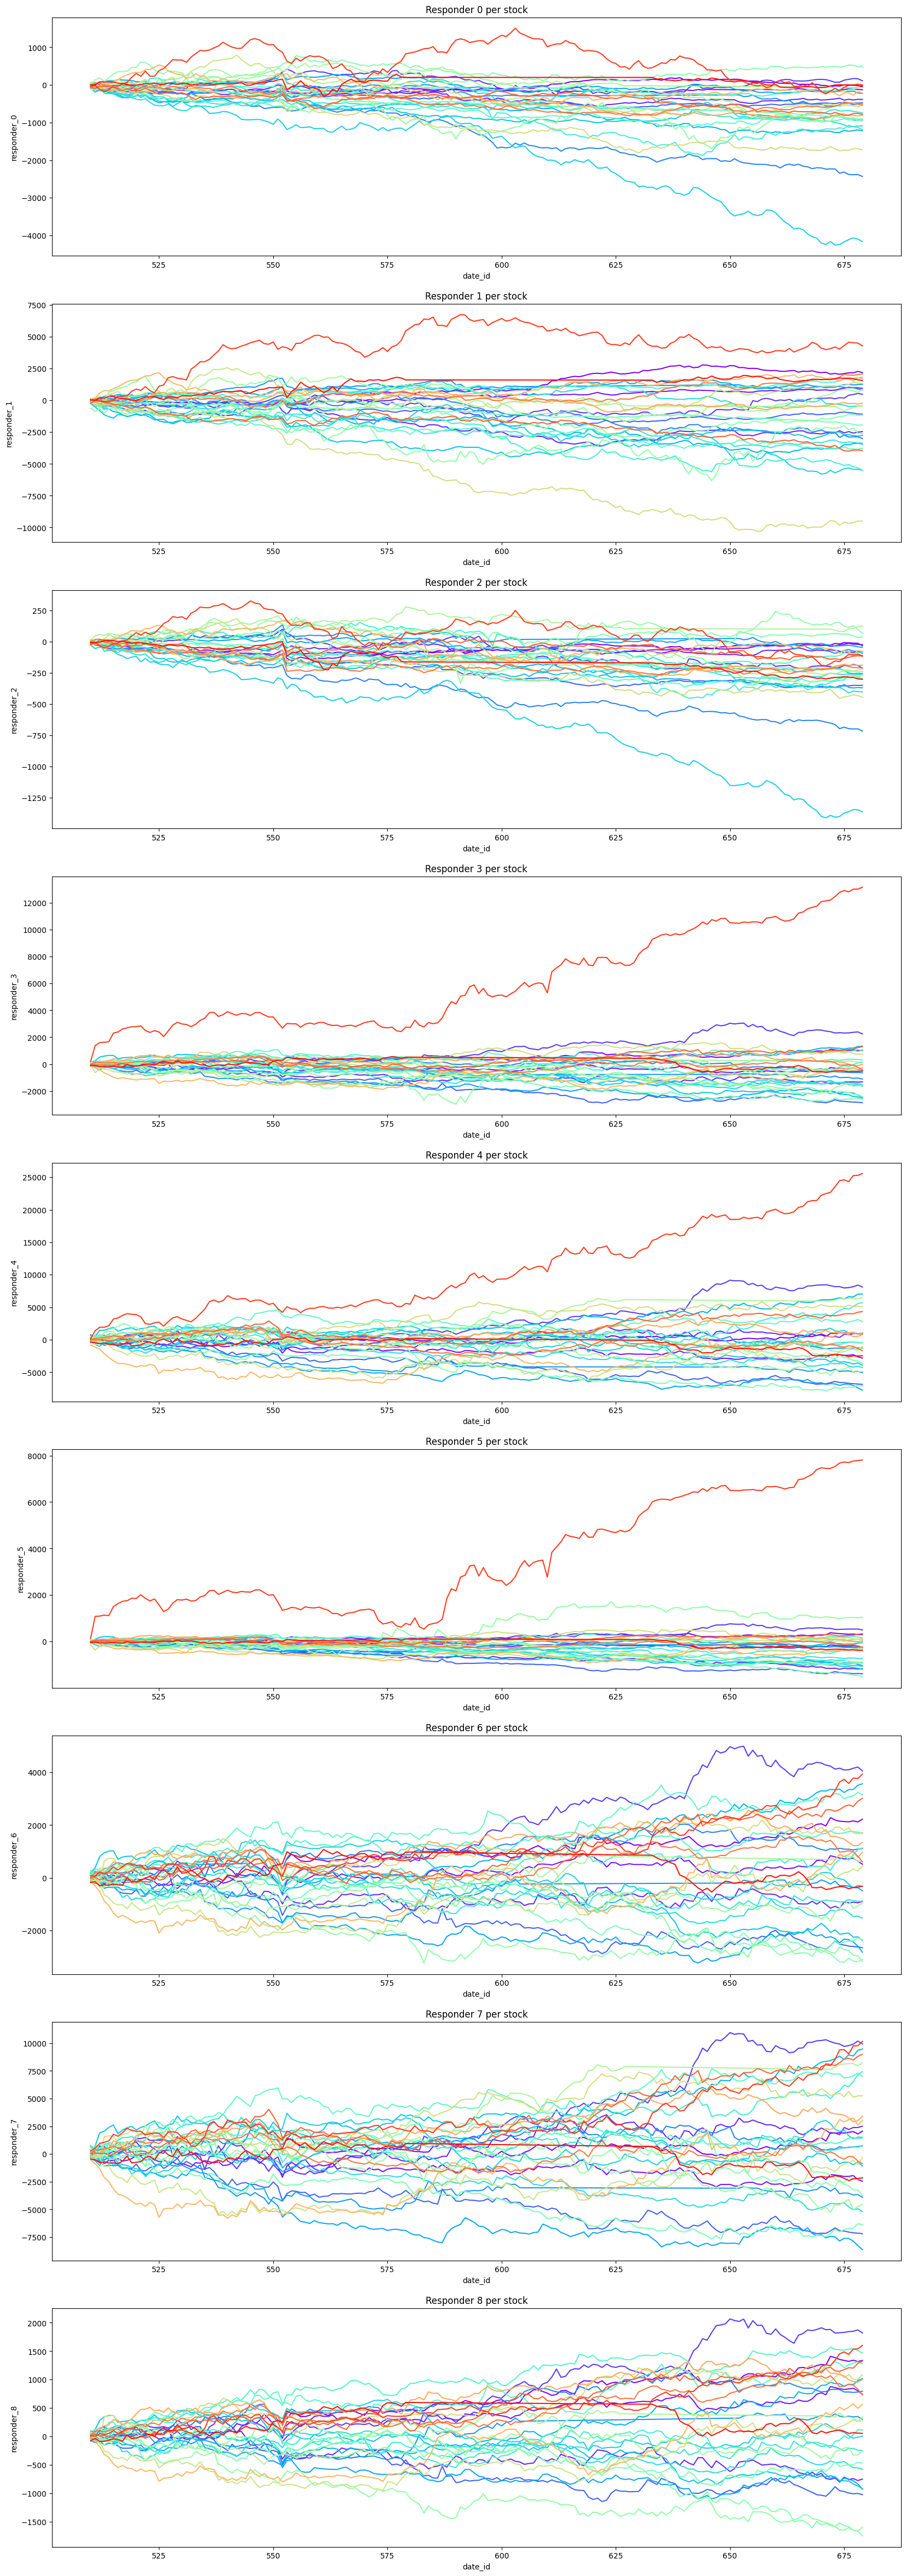

In [57]:
from matplotlib import cm

daily_responders = responders.group_by(['date_id', 'symbol_id']).agg(pl.col(RESPONDERS).sum())

colors = [cm.rainbow(i / 39)[:3] for i in range(39)]
fig, axes = plt.subplots(9, 1, figsize=(20, 60))

for i in range(9):
    for j in range(39):
        stock_data = daily_responders.filter(pl.col('symbol_id') == j).sort('date_id')
        axes[i].plot(stock_data['date_id'].to_numpy(), stock_data[f'responder_{i}'].to_numpy().cumsum(), color=colors[j])
    axes[i].set_xlabel('date_id')
    axes[i].set_ylabel(f'responder_{i}')
    axes[i].set_title(f'Responder {i} per stock')
    
plt.show()

In [58]:
time_responders = responders.group_by(['date_id', 'time_id']).agg(pl.col(RESPONDERS).sum())
time_responders.head()

shape: (5, 11)
┌─────────┬─────────┬────────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ responder_ ┆ responder_ ┆ … ┆ responder_ ┆ responder ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ 0          ┆ 1          ┆   ┆ 5          ┆ _6        ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│         ┆         ┆ f32        ┆ f32        ┆   ┆ f32        ┆ f32       ┆ f32       ┆ f32       │
╞═════════╪═════════╪════════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 600     ┆ 749     ┆ 1.843088   ┆ 1.199667   ┆ … ┆ 2.61026    ┆ -5.961134 ┆ -0.9276   ┆ -3.468754 │
│ 555     ┆ 698     ┆ 6.557106   ┆ -5.947924  ┆ … ┆ 1.855636   ┆ -5.73623  ┆ 3.76286   ┆ 2.024835  │
│ 574     ┆ 27      ┆ -7.961271  ┆ -8.259542  ┆ … ┆ 3.352067   ┆ -6.804643 ┆ 0.087919  ┆ 3.764436  │
│ 631     ┆ 94      ┆ -3.052754  ┆ -0.018049  ┆ … ┆ 6.778235   ┆ 6.042219  ┆ -3.829448 ┆ 14.36952  │
│ 632     ┆ 838     ┆ 1.280148   ┆ -3.187001  ┆ … ┆ 3.216581   ┆ 4.657671  ┆ 3.637827  ┆ 2.998857  │
└─────────┴─────────┴────────────┴────────────┴───┴────────────┴───────────┴───────────┴───────────┘

Responder 6 is not zero-sum at the same time (not normalized w.r.t. the market)

<Axes: ylabel='Count'>

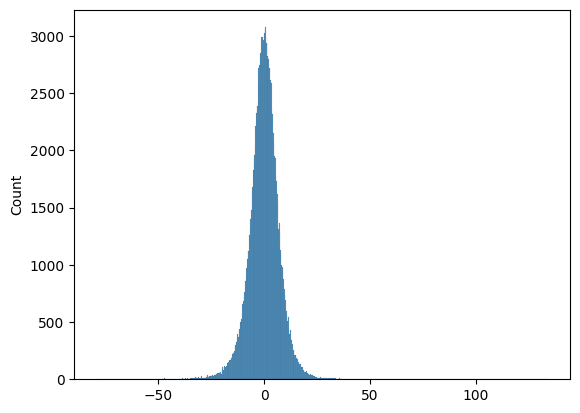

In [59]:
sns.histplot(time_responders['responder_6'].to_numpy())

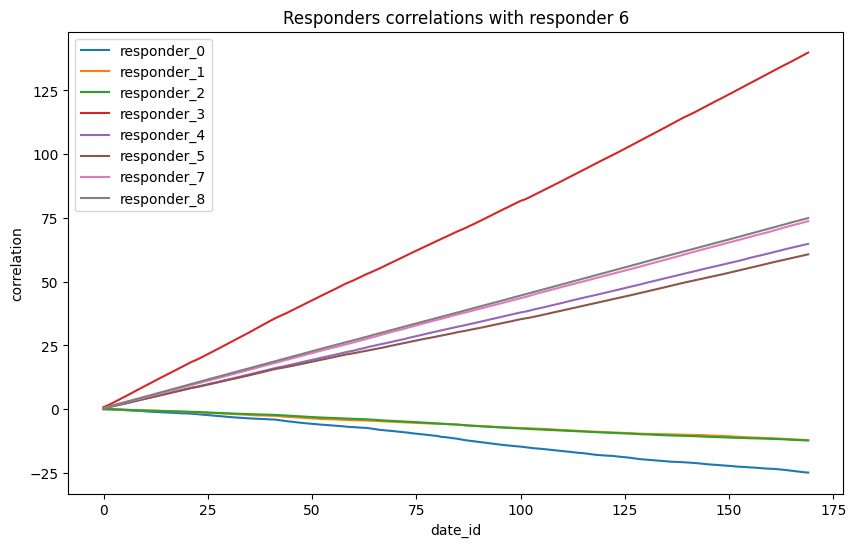

In [60]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'responder_{i}', 'responder_6') for i in range(9) if i != 6
).sort('date_id').with_columns(pl.col(f'responder_{i}').cum_sum() for i in range(9) if i != 6)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    if i != 6:
        ax.plot(daily_cumulative_correlations[f'responder_{i}'], label=f'responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Responders correlations with responder 6')
ax.legend()
plt.show()

# Lagged Responders

In [61]:
responders = train_ds.select(['date_id', 'time_id', 'symbol_id'] + [f'responder_{i}' for i in range(9)])

agg_responders = responders.group_by(['date_id', 'symbol_id']).agg(
    [pl.col(f'responder_{i}').sum().alias(f'total_responder_{i}') for i in range(9)] + \
    [pl.col(f'responder_{i}').mean().alias(f'mean_responder_{i}') for i in range(9)]
).with_columns(pl.col('date_id').add(1))
one_day_lagged_responders = responders.with_columns(pl.col('date_id').add(1))

responders = responders.join(agg_responders, on=['date_id', 'symbol_id'], how='left') \
    .join(one_day_lagged_responders, on=['date_id', 'time_id', 'symbol_id']) \
    .rename({f'responder_{i}_right': f'responder_{i}_lag_daily' for i in range(9)}) \
    .sort(['date_id', 'time_id', 'symbol_id'])
responders.tail(5)

shape: (5, 39)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5_lag_dail ┆ 6_lag_dail ┆ _7_lag_da ┆ _8_lag_da │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ y          ┆ y          ┆ ily       ┆ ily       │
│         ┆         ┆           ┆ f32        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆            ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 679     ┆ 967     ┆ 30        ┆ 1.381514   ┆ … ┆ 0.014907   ┆ -0.084757  ┆ -0.024905 ┆ -0.268241 │
│ 679     ┆ 967     ┆ 33        ┆ -0.430375  ┆ … ┆ -0.346775  ┆ -0.113587  ┆ -0.029769 ┆ -0.224148 │
│ 679     ┆ 967     ┆ 34        ┆ -0.664917  ┆ … ┆ 0.025817   ┆ 0.088597   ┆ 0.098648  ┆ 0.265459  │
│ 679     ┆ 967     ┆ 36        ┆ -1.309105  ┆ … ┆ 2.915394   ┆ -0.075657  ┆ -0.004163 ┆ -0.19892  │
│ 679     ┆ 967     ┆ 38        ┆ -0.042973  ┆ … ┆ -1.09842   ┆ -0.050557  ┆ 0.004535  ┆ -0.097565 │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

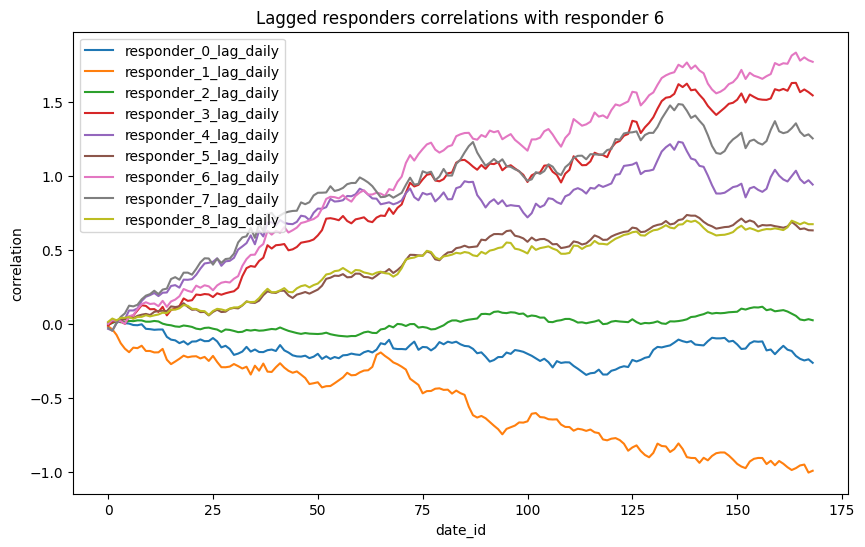

In [62]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'responder_{i}_lag_daily', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'responder_{i}_lag_daily').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'responder_{i}_lag_daily'], label=f'responder_{i}_lag_daily')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Lagged responders correlations with responder 6')
ax.legend()
plt.show()

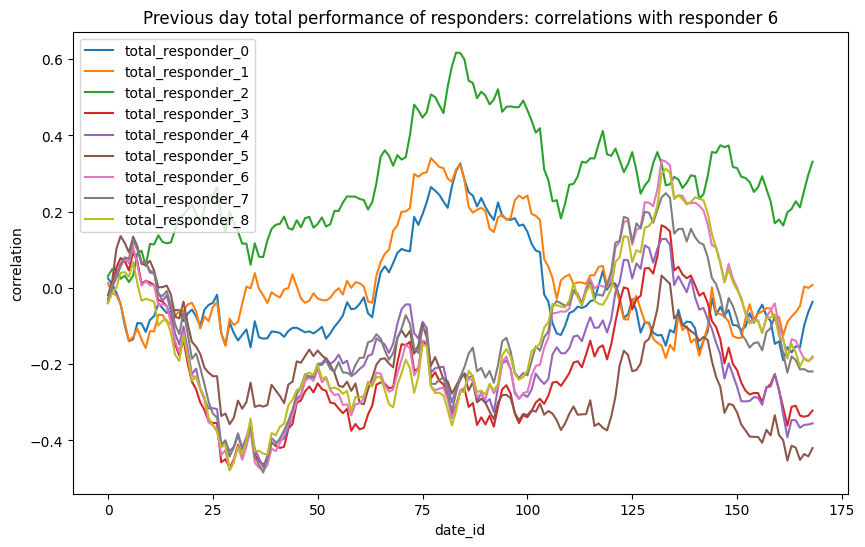

In [63]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'total_responder_{i}', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'total_responder_{i}').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'total_responder_{i}'], label=f'total_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Previous day total performance of responders: correlations with responder 6')
ax.legend()
plt.show()

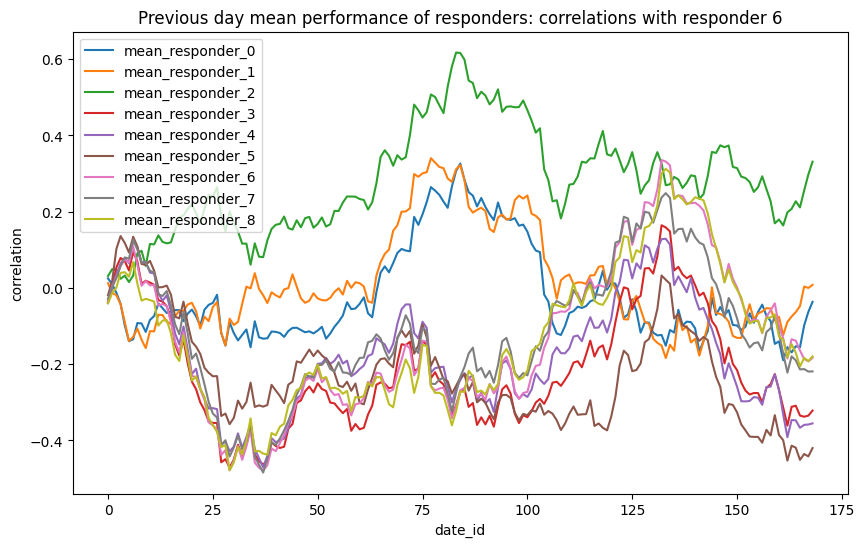

In [64]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'mean_responder_{i}', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'mean_responder_{i}').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'mean_responder_{i}'], label=f'mean_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Previous day mean performance of responders: correlations with responder 6')
ax.legend()
plt.show()

In [65]:
weekly_performances = responders.group_by(['date_id', 'symbol_id']).agg(
    [pl.col(f'responder_{i}_lag_daily').sum().alias(f'daily_performance_responder_{i}') for i in range(9)] + \
    [pl.col('time_id').count().alias('num_times')]
).with_columns(
    [pl.col(f'daily_performance_responder_{i}').rolling_sum(7, min_periods=1).alias(f'weekly_performance_responder_{i}') for i in range(9)] + \
    [pl.col('num_times').rolling_sum(7, min_periods=1).alias('num_times_week')]
).with_columns(
    pl.col(f'weekly_performance_responder_{i}').truediv('num_times_week').alias(f'weekly_mean_performance_responder_{i}') for i in range(9)
)
weekly_performances.tail()

shape: (5, 31)
┌─────────┬───────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ date_id ┆ symbol_id ┆ daily_perf ┆ daily_per ┆ … ┆ weekly_me ┆ weekly_me ┆ weekly_me ┆ weekly_me │
│ ---     ┆ ---       ┆ ormance_re ┆ formance_ ┆   ┆ an_perfor ┆ an_perfor ┆ an_perfor ┆ an_perfor │
│ i16     ┆ i8        ┆ sponder_0  ┆ responder ┆   ┆ mance_res ┆ mance_res ┆ mance_res ┆ mance_res │
│         ┆           ┆ ---        ┆ _1        ┆   ┆ pon…      ┆ pon…      ┆ pon…      ┆ pon…      │
│         ┆           ┆ f32        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆           ┆            ┆ f32       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═════════╪═══════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 612     ┆ 15        ┆ -70.33416  ┆ -123.5369 ┆ … ┆ 0.003708  ┆ 0.034878  ┆ 0.066242  ┆ 0.012028  │
│         ┆           ┆            ┆ 72        ┆   ┆           ┆           ┆           ┆           │
│ 603     ┆ 20        ┆ -50.386063 ┆ -76.66500 ┆ … ┆ 0.009638  ┆ 0.077945  ┆ 0.1519    ┆ 0.025534  │
│         ┆           ┆            ┆ 9         ┆   ┆           ┆           ┆           ┆           │
│ 521     ┆ 10        ┆ 32.326759  ┆ 104.59301 ┆ … ┆ 0.000635  ┆ 0.048535  ┆ 0.107253  ┆ 0.013591  │
│ 617     ┆ 20        ┆ -67.740799 ┆ -272.4487 ┆ … ┆ -0.005827 ┆ 0.004318  ┆ -0.005293 ┆ 0.000955  │
│         ┆           ┆            ┆ 61        ┆   ┆           ┆           ┆           ┆           │
│ 660     ┆ 7         ┆ -27.618038 ┆ -94.19934 ┆ … ┆ -0.00485  ┆ 0.005474  ┆ -0.030103 ┆ 0.002876  │
│         ┆           ┆            ┆ 1         ┆   ┆           ┆           ┆           ┆           │
└─────────┴───────────┴────────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

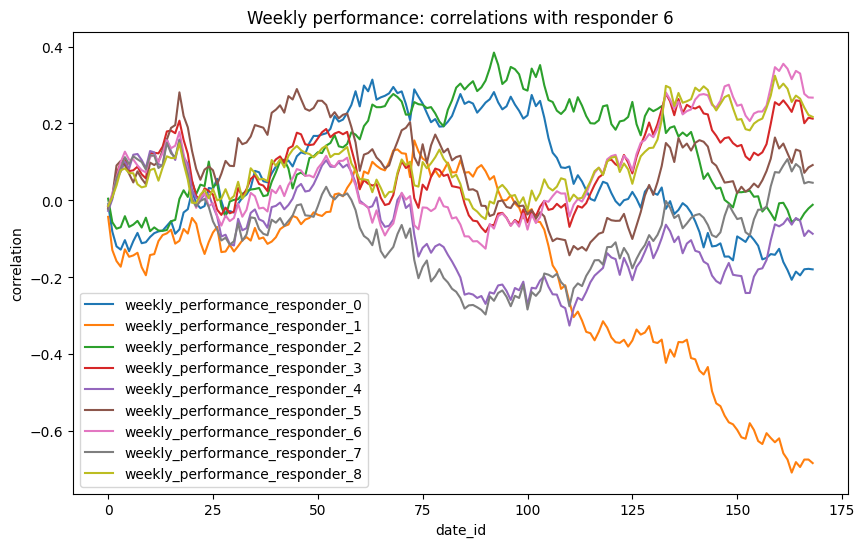

In [66]:
daily_cumulative_correlations = responders \
    .join(weekly_performances, on=['symbol_id', 'date_id']).group_by('date_id').agg(
        [pl.corr(f'weekly_performance_responder_{i}', 'responder_6') for i in range(9)] + \
        [pl.corr(f'weekly_mean_performance_responder_{i}', 'responder_6') for i in range(9)]
    ).sort('date_id')\
    .with_columns(
        *[pl.col(f'weekly_performance_responder_{i}').cum_sum() for i in range(9)],
        *[pl.col(f'weekly_mean_performance_responder_{i}').cum_sum() for i in range(9)]
    )

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'weekly_performance_responder_{i}'], label=f'weekly_performance_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Weekly performance: correlations with responder 6')
ax.legend()
plt.show()

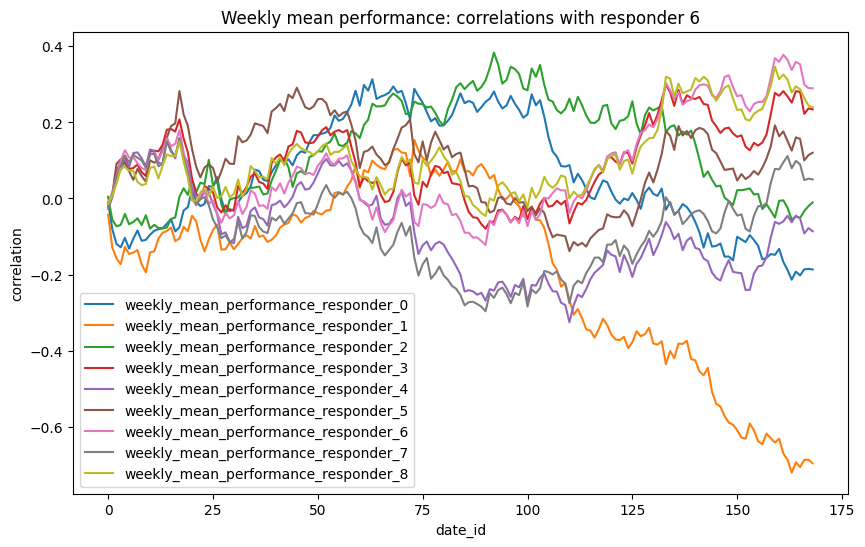

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'weekly_mean_performance_responder_{i}'], label=f'weekly_mean_performance_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Weekly mean performance: correlations with responder 6')
ax.legend()
plt.show()

In [68]:
responders = responders.sort(['date_id', 'time_id', 'symbol_id'])
responders.head(3)

shape: (3, 39)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5_lag_dail ┆ 6_lag_dail ┆ _7_lag_da ┆ _8_lag_da │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ y          ┆ y          ┆ ily       ┆ ily       │
│         ┆         ┆           ┆ f32        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆            ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 511     ┆ 0       ┆ 1         ┆ 0.117669   ┆ … ┆ 0.027439   ┆ 1.896684   ┆ 0.769314  ┆ 0.336645  │
│ 511     ┆ 0       ┆ 2         ┆ -0.034766  ┆ … ┆ -0.339655  ┆ -1.810862  ┆ -0.42353  ┆ -0.868464 │
│ 511     ┆ 0       ┆ 3         ┆ -0.570115  ┆ … ┆ 3.077065   ┆ 2.597628   ┆ -0.263473 ┆ 5.0       │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [69]:
features = [f'responder_{i}_lag_daily' for i in range(9)] + [f'total_responder_{i}' for i in range(9)] + [f'mean_responder_{i}' for i in range(9)]
target = 'responder_6'
daily_corr = responders.group_by(['date_id']).agg(
    pl.corr(f, target).name.keep() for f in features
).with_columns(
    #Flip sign for negative mean correlation since we only care about magnitude
    pl.all().exclude('date_id').mul(pl.all().exclude('date_id').mean().sign()).name.keep()
).sort('date_id')
daily_corr

shape: (169, 28)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ date_id ┆ responder_ ┆ responder ┆ responder ┆ … ┆ mean_resp ┆ mean_resp ┆ mean_resp ┆ mean_resp │
│ ---     ┆ 0_lag_dail ┆ _1_lag_da ┆ _2_lag_da ┆   ┆ onder_5   ┆ onder_6   ┆ onder_7   ┆ onder_8   │
│ i16     ┆ y          ┆ ily       ┆ ily       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│         ┆ f64        ┆ f64       ┆ f64       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 511     ┆ 0.002097   ┆ 0.016113  ┆ -0.005663 ┆ … ┆ 0.019439  ┆ 0.033253  ┆ 0.028978  ┆ 0.040765  │
│ 512     ┆ -0.012701  ┆ 0.0214    ┆ 0.011403  ┆ … ┆ -0.0376   ┆ -0.037569 ┆ -0.030795 ┆ -0.026729 │
│ 513     ┆ -0.01329   ┆ 0.036936  ┆ 0.011457  ┆ … ┆ -0.083915 ┆ -0.023953 ┆ -0.023963 ┆ -0.014542 │
│ 514     ┆ 0.003563   ┆ 0.056481  ┆ -0.006375 ┆ … ┆ -0.033546 ┆ -0.029381 ┆ -0.031546 ┆ -0.03872  │
│ 515     ┆ 0.015603   ┆ 0.037042  ┆ -0.000389 ┆ … ┆ 0.018094  ┆ -0.016014 ┆ -0.022292 ┆ -0.001741 │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 675     ┆ 0.033447   ┆ -0.012688 ┆ -0.014499 ┆ … ┆ 0.005147  ┆ 0.003849  ┆ 0.010195  ┆ 0.022748  │
│ 676     ┆ 0.01997    ┆ -0.018241 ┆ -0.024765 ┆ … ┆ 0.032014  ┆ 0.025939  ┆ 0.023943  ┆ 0.036044  │
│ 677     ┆ 0.010664   ┆ -0.005844 ┆ -0.005102 ┆ … ┆ -0.015347 ┆ 0.021881  ┆ -0.000736 ┆ -0.022618 │
│ 678     ┆ -0.007646  ┆ 0.054176  ┆ 0.00731   ┆ … ┆ 0.00615   ┆ 0.006196  ┆ 0.006444  ┆ 0.008729  │
│ 679     ┆ 0.023517   ┆ -0.012457 ┆ -0.007206 ┆ … ┆ -0.021853 ┆ -0.008982 ┆ -0.000397 ┆ -0.012569 │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [70]:
def metrics(corr):
    corr_mean = corr.mean()
    corr_std = corr.std(ddof=0)
    corr_sharpe = corr_mean / corr_std
    max_drawdown = -(corr.cumsum().expanding(min_periods=1).max() - corr.cumsum()).max()

    eras = daily_corr['date_id'].unique().sort().to_list()
    halfway_era = len(eras)//2
    corr_mean_first_half = corr.loc[eras[:halfway_era]].mean()
    corr_mean_second_half = corr.loc[eras[halfway_era:]].mean()

    delta = abs(corr_mean_first_half - corr_mean_second_half)

    return {
      "mean": corr_mean,
      "std": corr_std,
      "sharpe": corr_sharpe,
      "max_drawdown": max_drawdown,
      "delta": delta
    }

per_era_corr = daily_corr.to_pandas().set_index('date_id')
# compute performance metrics for each feature
feature_metrics = [
    metrics(per_era_corr[feature_name])
    for feature_name in features
]

# convert to numeric DataFrame and sort
feature_metrics = (
    pd.DataFrame(feature_metrics, index=features)
    .apply(pd.to_numeric)
    .sort_values("mean", ascending=False)
)

feature_metrics

mean       std    sharpe  max_drawdown     delta
responder_6_lag_daily  0.010488  0.032580  0.321910     -0.208632  0.009187
responder_3_lag_daily  0.009145  0.032441  0.281896     -0.211510  0.007612
responder_7_lag_daily  0.007423  0.036651  0.202527     -0.336883  0.010849
responder_1_lag_daily  0.005879  0.026783  0.219513     -0.236398  0.001007
responder_4_lag_daily  0.005575  0.034857  0.159947     -0.376019  0.010642
responder_8_lag_daily  0.003989  0.017095  0.233368     -0.100375  0.003442
responder_5_lag_daily  0.003741  0.017387  0.215184     -0.118944  0.004679
total_responder_5      0.002488  0.032920  0.075564     -0.406357  0.001143
mean_responder_5       0.002488  0.032920  0.075564     -0.406357  0.001143
total_responder_4      0.002105  0.034809  0.060480     -0.599691  0.002106
mean_responder_4       0.002105  0.034809  0.060480     -0.599691  0.002106
mean_responder_2       0.001958  0.031871  0.061426     -0.453599  0.010712
total_responder_2      0.001958  0.031871  0.061426     -0.453599  0.010712
mean_responder_3       0.001906  0.034307  0.055553     -0.635641  0.003501
total_responder_3      0.001906  0.034307  0.055553     -0.635641  0.003501
responder_0_lag_daily  0.001559  0.020663  0.075439     -0.251194  0.000240
mean_responder_7       0.001298  0.035045  0.037041     -0.733054  0.003938
total_responder_7      0.001298  0.035045  0.037041     -0.733054  0.003938
total_responder_6      0.001088  0.034995  0.031079     -0.814244  0.005188
mean_responder_6       0.001088  0.034995  0.031079     -0.814244  0.005188
total_responder_8      0.001065  0.034918  0.030505     -0.790978  0.005547
mean_responder_8       0.001065  0.034918  0.030505     -0.790978  0.005547
total_responder_0      0.000218  0.031237  0.006983     -0.481924  0.007686
mean_responder_0       0.000218  0.031237  0.006983     -0.481924  0.007686
responder_2_lag_daily  0.000145  0.009999  0.014459     -0.108986  0.000265
total_responder_1      0.000045  0.031717  0.001416     -0.524373  0.007268
mean_responder_1       0.000045  0.031717  0.001416     -0.524373  0.007268

array([[<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'std'}>,
        <Axes: title={'center': 'sharpe'}>],
       [<Axes: title={'center': 'max_drawdown'}>,
        <Axes: title={'center': 'delta'}>, <Axes: >]], dtype=object)

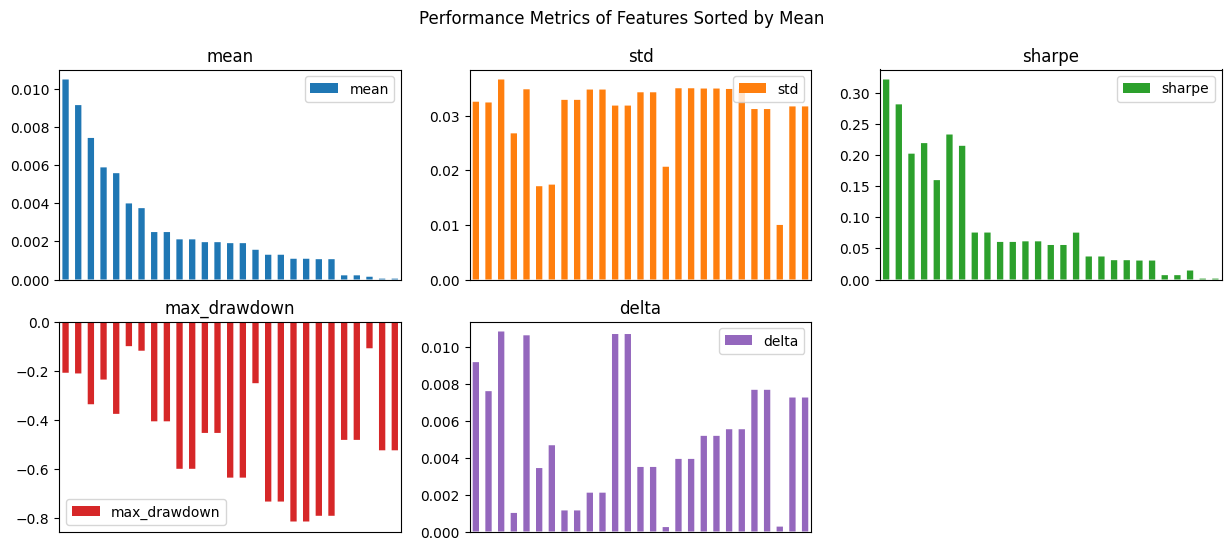

In [71]:
feature_metrics.sort_values("mean", ascending=False).plot.bar(
    title="Performance Metrics of Features Sorted by Mean",
    subplots=True,
    figsize=(15, 6),
    layout=(2, 3),
    sharex=False,
    xticks=[],
    snap=False
)

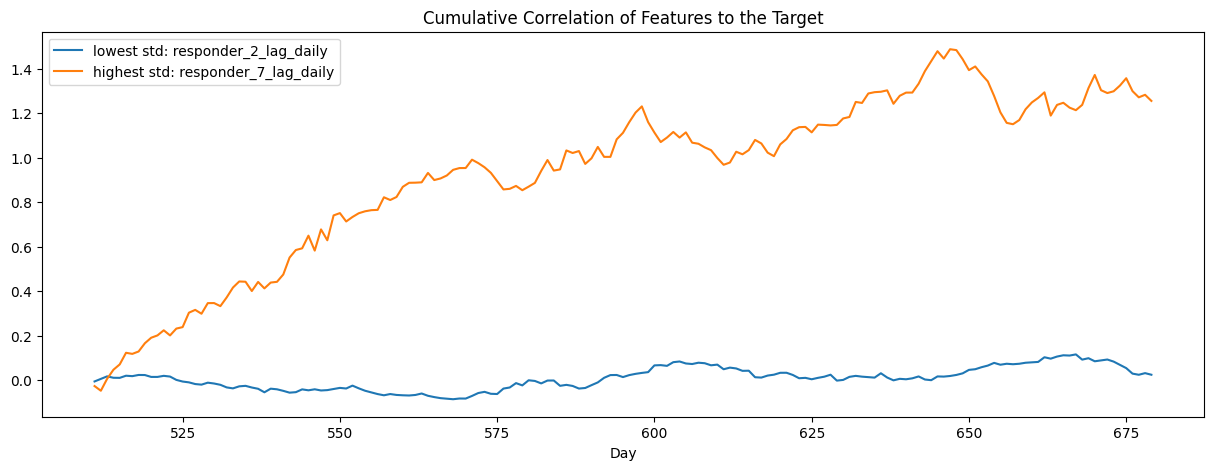

In [72]:
metric="std"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])

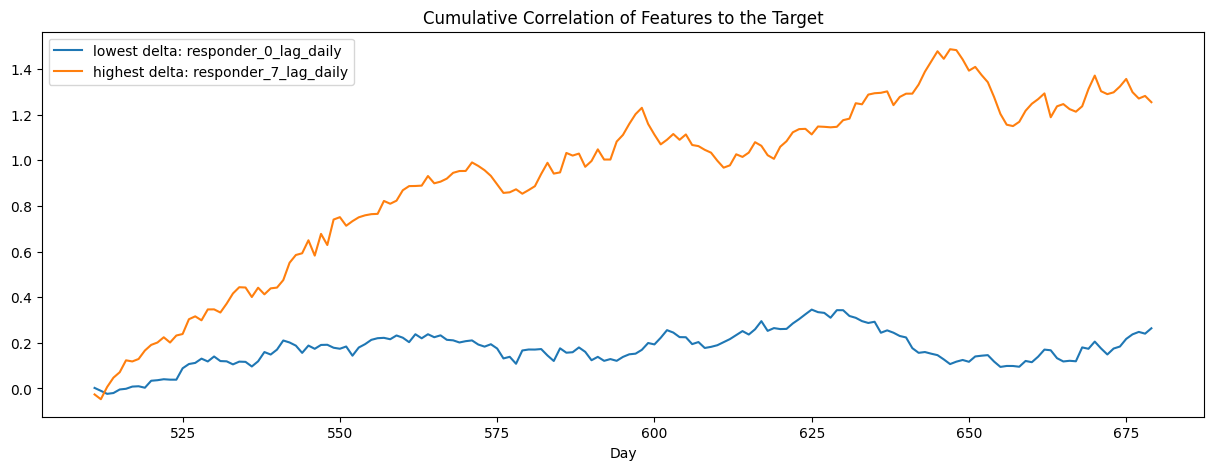

In [73]:
metric="delta"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])

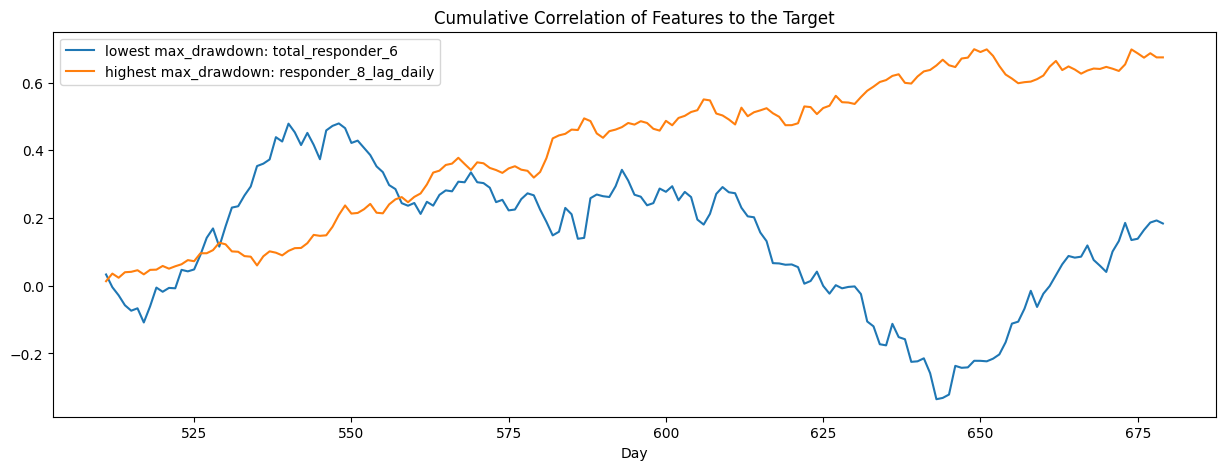

In [74]:
metric="max_drawdown"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])